# SSRT Soil–Vegetation Backscatter Integration

We first validate the SPM3D soil backscatter model against the NMM3D 40° look-up table, then demonstrate how the SSRT/S2RTR core combines soil and vegetation to produce total σ₀ under varying incidence angles and canopy optical depths.


**Workflow**

1. Reproduce NMM3D curves for each ℓ/σ ratio and compare SPM3D VV/HH/HV predictions.
2. Quantify VV/HH errors vs. the LUT for transparency.
3. Pick a representative soil case and generate a bare-soil incidence-angle sweep (SPM3D vs. SSRT ground-only).
4. Explore vegetation impacts by varying incidence angle and extinction coefficient, with multiple albedo settings.
5. Visualise the vegetation uplift via line plots, heatmaps, and summary tables.


In [11]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mwrtms.rt import S2RTR
from mwrtms.rt.surface.spm import SPM3D
from mwrtms.rt.utils.util import toLambda

plt.style.use('seaborn-v0_8-whitegrid')

NOTEBOOK_ROOT = Path.cwd().resolve()
DATA_DIR = NOTEBOOK_ROOT / 'data'
if not DATA_DIR.exists():
    DATA_DIR = NOTEBOOK_ROOT.parent / 'data'

MPL_CACHE = NOTEBOOK_ROOT / '.mpl-cache'
MPL_CACHE.mkdir(exist_ok=True)
os.environ.setdefault('MPLCONFIGDIR', str(MPL_CACHE))

LUT_PATH = DATA_DIR / 'NMM3D_LUT_NRCS_40degree.dat'
if not LUT_PATH.exists():
    raise FileNotFoundError('NMM3D LUT not found')

lut = np.loadtxt(LUT_PATH)

FREQUENCY_GHZ = 5.405
INCIDENCE_DEG = 40.0
lambda_m = toLambda(FREQUENCY_GHZ)
TARGET_RATIOS = [4.0, 7.0, 10.0, 15.0]
COLORS = plt.cm.tab10(np.linspace(0, 0.75, len(TARGET_RATIOS)))
MARKERS = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x']


In [12]:
ratio_groups = {}
metrics_rows = []

for ratio_idx, ratio in enumerate(TARGET_RATIOS):
    mask_ratio = np.isclose(lut[:, 1], ratio)
    block = lut[mask_ratio]
    if block.size == 0:
        continue
    unique_eps = np.unique(block[:, 2:4], axis=0)
    ratio_groups[ratio] = []

    for eps_r, eps_i in unique_eps:
        sub = block[np.isclose(block[:, 2], eps_r) & np.isclose(block[:, 3], eps_i)]
        rms_norm = sub[:, 4]
        sigmas = rms_norm * lambda_m
        corr_lengths = ratio * sigmas

        spm = SPM3D(
            fr=FREQUENCY_GHZ,
            sig=sigmas,
            L=corr_lengths,
            thi=INCIDENCE_DEG,
            eps=complex(eps_r, eps_i)
        )
        vv_model, hh_model, hv_model, _ = spm.calc_sigma()

        entry = {
            'eps_r': eps_r,
            'eps_i': eps_i,
            'k_sigma': 2 * np.pi * rms_norm,
            'vv_ref': sub[:, 5],
            'hh_ref': sub[:, 6],
            'hv_ref': sub[:, 7],
            'vv_model': vv_model,
            'hh_model': hh_model,
            'hv_model': hv_model,
        }
        ratio_groups[ratio].append(entry)

        for band_key, band_label in [('vv', 'VV'), ('hh', 'HH')]:
            ref = entry[f'{band_key}_ref']
            mod = entry[f'{band_key}_model']
            mask = np.isfinite(ref) & np.isfinite(mod)
            if not np.any(mask):
                continue
            diff = mod[mask] - ref[mask]
            metrics_rows.append({
                'ratio': ratio,
                'εr': eps_r,
                'εi': eps_i,
                'Band': band_label,
                'N': diff.size,
                'RMSE (dB)': float(np.sqrt(np.mean(diff**2))),
                'Bias (dB)': float(np.mean(diff)),
                'MAE (dB)': float(np.mean(np.abs(diff))),
                'Corr r': float(np.corrcoef(ref[mask], mod[mask])[0, 1]) if diff.size > 1 else np.nan,
            })

metrics_df = pd.DataFrame(metrics_rows).set_index(['ratio', 'εr', 'εi', 'Band'])
metrics_df.head()


N  RMSE (dB)  Bias (dB)  MAE (dB)    Corr r
ratio εr  εi  Band                                             
4.0   3.0 1.0 VV    6   2.295800   2.202560  2.202560  0.999745
              HH    6   0.833910   0.262813  0.740788  0.999100
      5.5 2.0 VV    6   3.577736   3.350107  3.350107  0.999410
              HH    6   0.649811  -0.297728  0.411258  0.999784
      9.0 2.5 VV    6   3.487187   3.195959  3.195959  0.998693

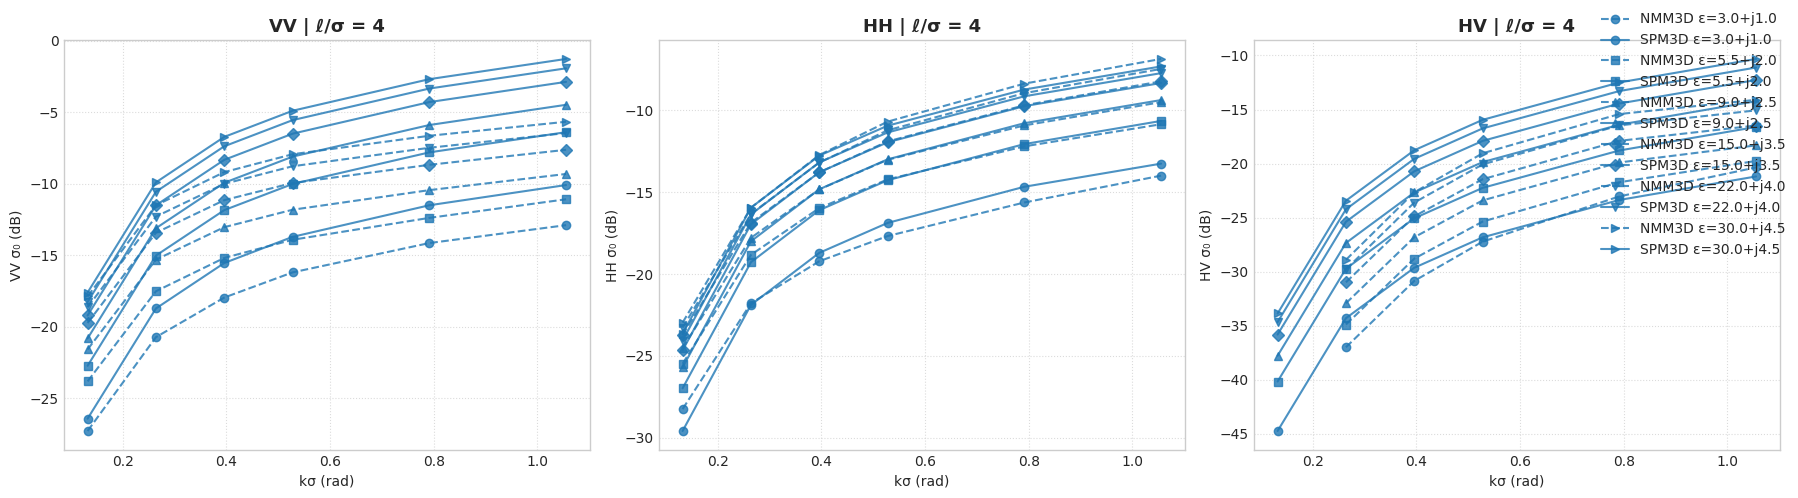

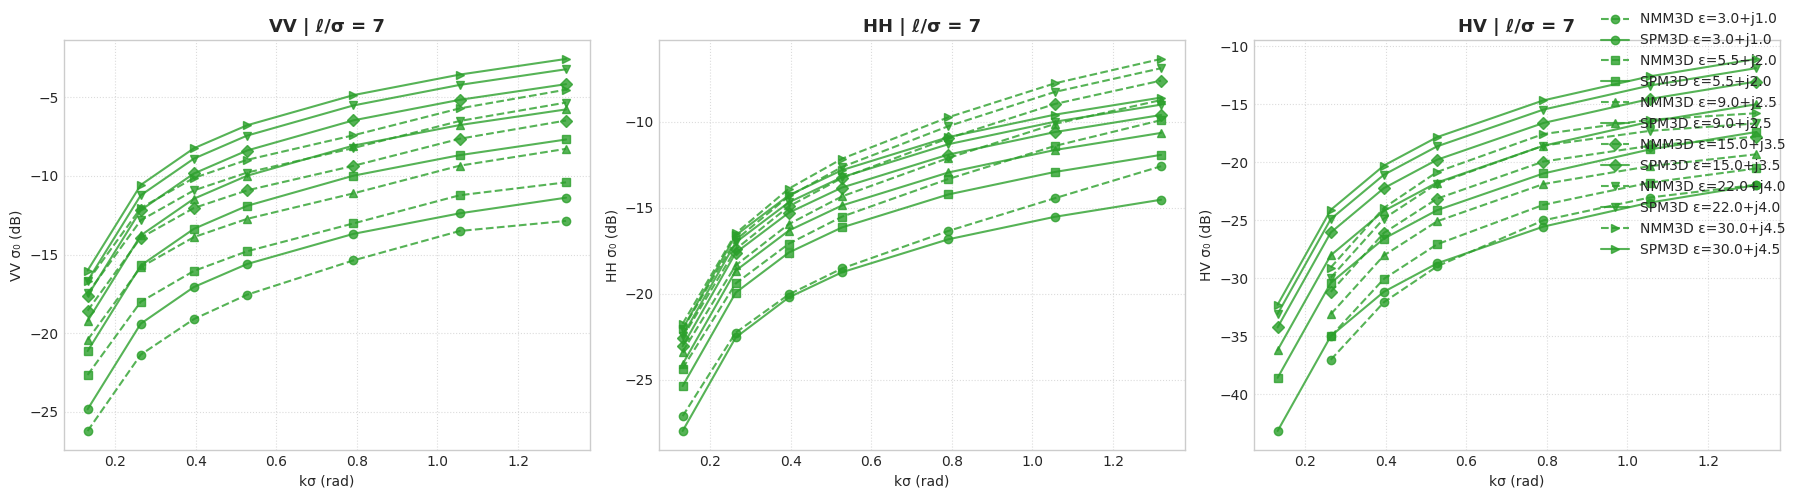

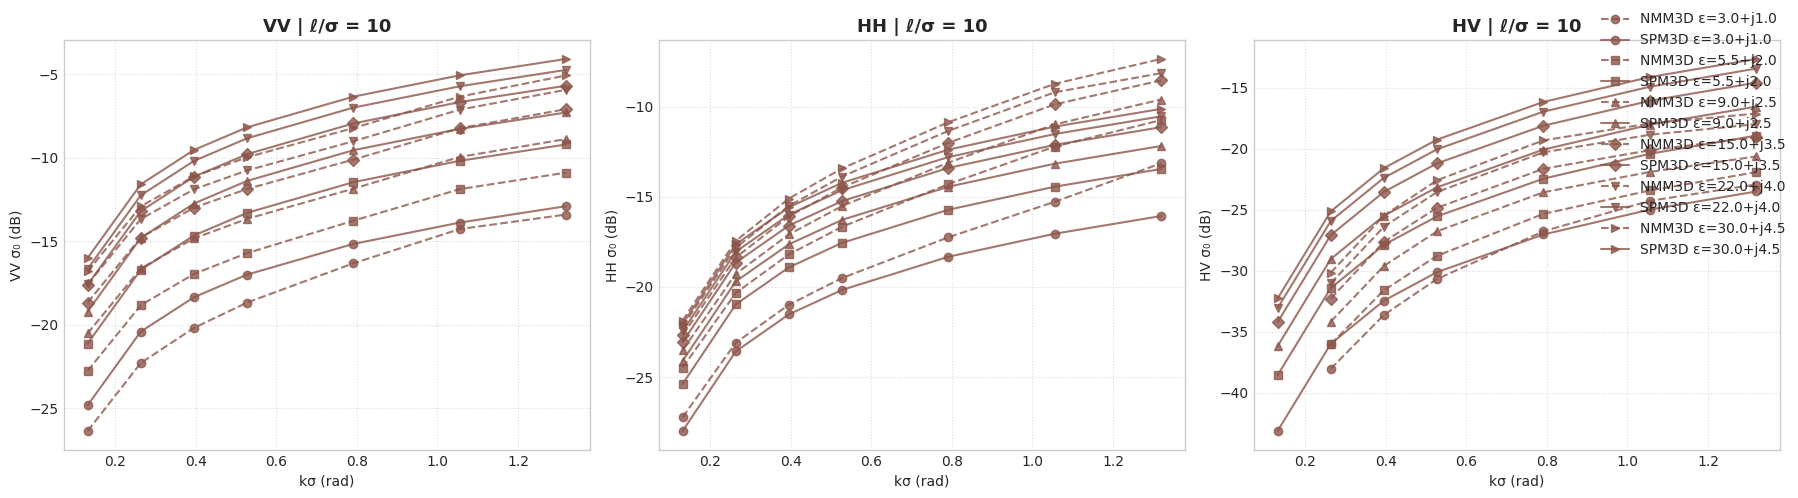

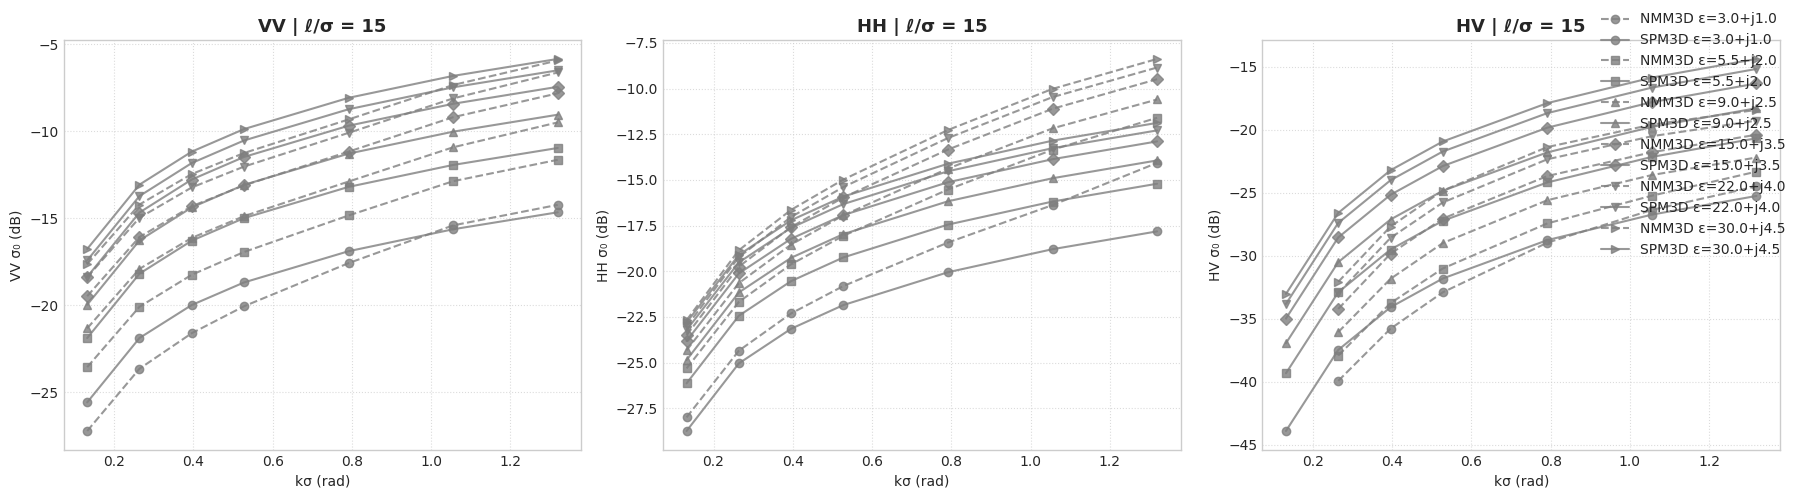

In [13]:
for ratio_idx, ratio in enumerate(TARGET_RATIOS):
    groups = ratio_groups.get(ratio)
    if not groups:
        continue
    color = COLORS[ratio_idx]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)
    bands = [
        ('vv', 'VV σ₀ (dB)', 'VV'),
        ('hh', 'HH σ₀ (dB)', 'HH'),
        ('hv', 'HV σ₀ (dB)', 'HV'),
    ]
    for ax, (band_key, ylabel, title) in zip(axes, bands):
        for eps_idx, entry in enumerate(groups):
            label = f"ε={entry['eps_r']:.1f}+j{entry['eps_i']:.1f}"
            marker = MARKERS[eps_idx % len(MARKERS)]
            ax.plot(entry['k_sigma'], entry[f'{band_key}_ref'], marker=marker, linestyle='--', color=color,
                    label=f'NMM3D {label}' if band_key == 'vv' else None, alpha=0.8)
            ax.plot(entry['k_sigma'], entry[f'{band_key}_model'], marker=marker, linestyle='-', color=color,
                    label=f'SPM3D {label}' if band_key == 'vv' else None, alpha=0.8)
        ax.set_title(f'{title} | ℓ/σ = {ratio:g}', fontsize=13, fontweight='semibold')
        ax.set_xlabel('kσ (rad)')
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle=':', alpha=0.7)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper right')
    fig.tight_layout()
    plt.show()


In [14]:
summary_table = metrics_df.groupby(['ratio', 'Band']).agg({
    'RMSE (dB)': 'mean',
    'Bias (dB)': 'mean',
    'MAE (dB)': 'mean',
    'Corr r': 'mean'
}).round(3)
summary_table


RMSE (dB)  Bias (dB)  MAE (dB)  Corr r
ratio Band                                        
4.0   HH        0.515     -0.158     0.362   0.999
      VV        3.125      2.853     2.853   0.999
7.0   HH        1.097     -0.896     0.896   0.995
      VV        2.152      2.088     2.088   0.998
10.0  HH        1.474     -1.203     1.203   0.994
      VV        1.674      1.622     1.622   0.996
15.0  HH        1.894     -1.529     1.529   0.993
      VV        1.288      1.161     1.192   0.995

In [15]:
# --- Baseline soil configuration across incidence angles ---
target_ratio = 10.0
target_eps = (9.0, 2.5)
base_group = None
for entry in ratio_groups.get(target_ratio, []):
    if np.isclose(entry['eps_r'], target_eps[0]) and np.isclose(entry['eps_i'], target_eps[1]):
        base_group = entry
        break

if base_group is None:
    raise RuntimeError('Target soil case not located in ratio_groups')

idx = len(base_group['k_sigma']) // 2
rms_norm = float(base_group['k_sigma'][idx] / (2 * np.pi))
soil_sigma = rms_norm * lambda_m
soil_corr = float(target_ratio * soil_sigma)
angles = np.arange(20, 65, 5)

baseline_vv_spm, baseline_hh_spm = [], []
s2_vv_ground, s2_hh_ground = [], []

for theta in angles:
    spm_theta = SPM3D(
        fr=FREQUENCY_GHZ,
        sig=soil_sigma,
        L=soil_corr,
        thi=theta,
        eps=complex(*target_eps)
    )
    vv_theta, hh_theta, _, _ = spm_theta.calc_sigma()
    baseline_vv_spm.append(float(vv_theta))
    baseline_hh_spm.append(float(hh_theta))

    rt_theta = S2RTR(
        frq_GHz=FREQUENCY_GHZ,
        theta_i=theta,
        theta_s=theta,
        phi_i=0.0,
        phi_s=180.0,
        s=soil_sigma,
        cl=soil_corr,
        eps2=np.array([1.0 + 0.0j]),
        eps3=np.array([complex(*target_eps)]),
        a=0.0,
        kappa_e=1e-6,
        d=1e-3,
        acftype='exp',
        RT_models={'RT_s': 'SPM3D', 'RT_c': 'Spec'}
    )
    _, ground_only, _ = rt_theta.calc_sigma(todB=True)
    s2_vv_ground.append(float(ground_only['vv']))
    s2_hh_ground.append(float(ground_only['hh']))

baseline_df = pd.DataFrame({
    'Incidence (deg)': angles,
    'SPM3D VV (dB)': baseline_vv_spm,
    'S2RTR ground VV (dB)': s2_vv_ground,
    'SPM3D HH (dB)': baseline_hh_spm,
    'S2RTR ground HH (dB)': s2_hh_ground,
})

baseline_vv = np.array(s2_vv_ground)
baseline_hh = np.array(s2_hh_ground)

baseline_df


/tmp/ipykernel_2584307/2535583351.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s2_vv_ground.append(float(ground_only['vv']))
/tmp/ipykernel_2584307/2535583351.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s2_hh_ground.append(float(ground_only['hh']))


,Incidence (deg),SPM3D VV (dB),S2RTR ground VV (dB),SPM3D HH (dB),S2RTR ground HH (dB)
0,20,-4.486369,-4.486369,-5.847415,-5.847415
1,25,-6.805988,-6.805988,-8.881132,-8.881132
2,30,-8.634075,-8.634075,-11.542647,-11.542647
3,35,-10.126819,-10.126819,-13.975640,-13.975640
4,40,-11.396468,-11.396468,-16.284249,-16.284249
5,45,-12.530887,-12.530887,-18.553735,-18.553735
6,50,-13.606319,-13.606319,-20.864089,-20.864089
7,55,-14.698052,-14.698052,-23.301614,-23.301614
8,60,-15.892850,-15.892850,-25.972638,-25.972638


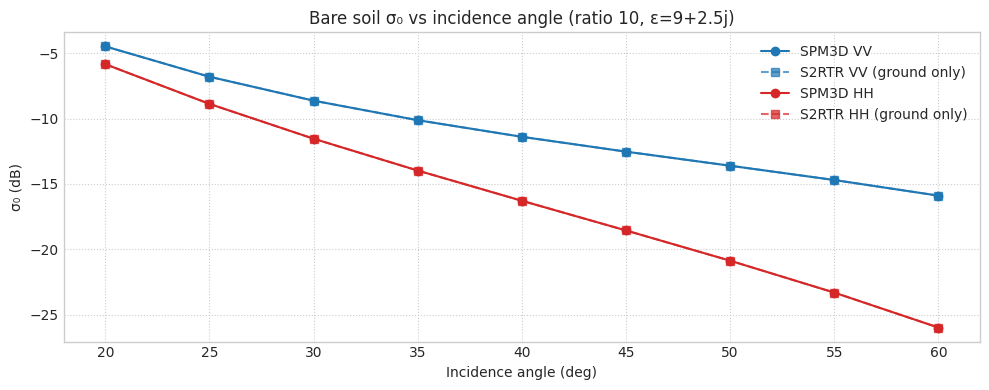

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(angles, baseline_vv_spm, 'o-', label='SPM3D VV', color='#1f77b4')
plt.plot(angles, s2_vv_ground, 's--', label='S2RTR VV (ground only)', color='#1f77b4', alpha=0.7)
plt.plot(angles, baseline_hh_spm, 'o-', label='SPM3D HH', color='#d62728')
plt.plot(angles, s2_hh_ground, 's--', label='S2RTR HH (ground only)', color='#d62728', alpha=0.7)
plt.title('Bare soil σ₀ vs incidence angle (ratio 10, ε=9+2.5j)')
plt.xlabel('Incidence angle (deg)')
plt.ylabel('σ₀ (dB)')
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# --- Vegetation parameter sweep ---
albedos = [0.03, 0.08]
kappas = [0.2, 0.4, 0.7, 1.0]
canopy_eps = 12.0 + 3.0j
canopy_thickness = 0.35  # m

canopy_results = {a: {} for a in albedos}

for albedo in albedos:
    for kappa in kappas:
        total_vv, total_hh = [], []
        ground_vv, ground_hh = [], []
        for theta in angles:
            rt = S2RTR(
                frq_GHz=FREQUENCY_GHZ,
                theta_i=theta,
                theta_s=theta,
                phi_i=0.0,
                phi_s=180.0,
                s=soil_sigma,
                cl=soil_corr,
                eps2=np.array([canopy_eps]),
                eps3=np.array([complex(*target_eps)]),
                a=albedo,
                kappa_e=kappa,
                d=canopy_thickness,
                acftype='exp',
                RT_models={'RT_s': 'SPM3D', 'RT_c': 'Spec'}
            )
            _, ground_layer, total_layer = rt.calc_sigma(todB=True)
            ground_vv.append(float(ground_layer['vv']))
            ground_hh.append(float(ground_layer['hh']))
            total_vv.append(float(total_layer['vv']))
            total_hh.append(float(total_layer['hh']))
        total_vv = np.array(total_vv)
        total_hh = np.array(total_hh)
        ground_vv = np.array(ground_vv)
        ground_hh = np.array(ground_hh)
        canopy_results[albedo][kappa] = {
            'total_vv': total_vv,
            'total_hh': total_hh,
            'ground_vv': ground_vv,
            'ground_hh': ground_hh,
            'uplift_vv': total_vv - baseline_vv,
            'uplift_hh': total_hh - baseline_hh,
        }


/tmp/ipykernel_2584307/498326598.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_vv.append(float(ground_layer['vv']))
/tmp/ipykernel_2584307/498326598.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_hh.append(float(ground_layer['hh']))
/tmp/ipykernel_2584307/498326598.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_vv.append(float(total_layer['vv']))
/tmp/ipykernel_2584307/498326598.py:34: DeprecationWarning: Conversion of an arra

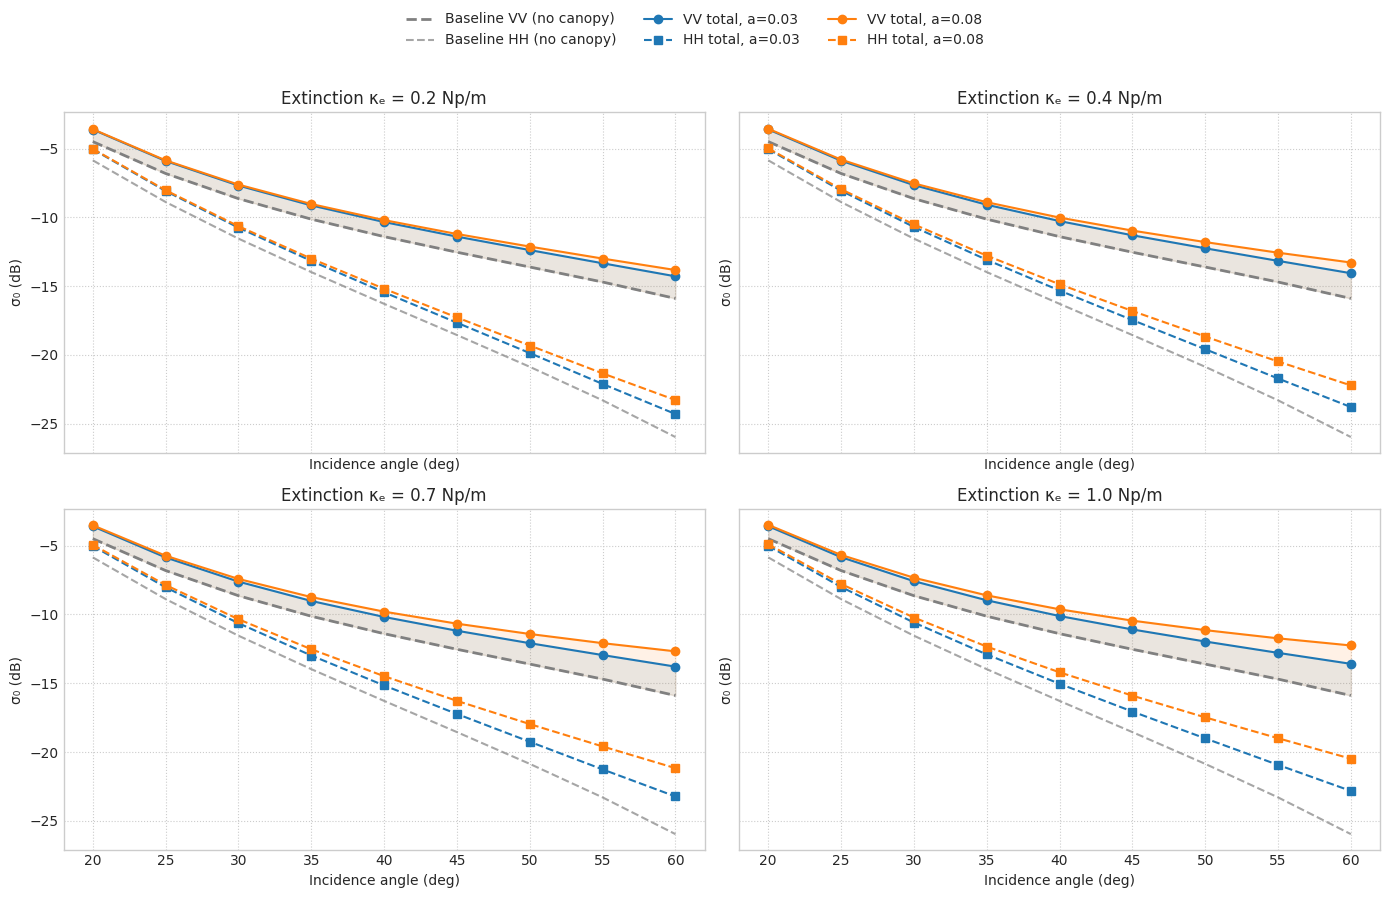

In [18]:
albedo_colors = {0.03: '#1f77b4', 0.08: '#ff7f0e'}
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=True)
axes = axes.ravel()
for ax, kappa in zip(axes, kappas):
    ax.plot(angles, baseline_vv, '--', color='gray', linewidth=2, label='Baseline VV (no canopy)')
    ax.plot(angles, baseline_hh, '--', color='gray', linewidth=1.5, alpha=0.7, label='Baseline HH (no canopy)')
    for albedo in albedos:
        res = canopy_results[albedo][kappa]
        ax.plot(angles, res['total_vv'], marker='o', color=albedo_colors[albedo], label=f'VV total, a={albedo:.02f}')
        ax.plot(angles, res['total_hh'], marker='s', color=albedo_colors[albedo], linestyle='--', label=f'HH total, a={albedo:.02f}')
        ax.fill_between(angles, baseline_vv, res['total_vv'], color=albedo_colors[albedo], alpha=0.1)
    ax.set_title(f'Extinction κₑ = {kappa} Np/m')
    ax.set_xlabel('Incidence angle (deg)')
    ax.set_ylabel('σ₀ (dB)')
    ax.grid(True, linestyle=':')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
# fig.suptitle('Total σ₀ with vegetation vs. baseline soil', fontsize=14, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


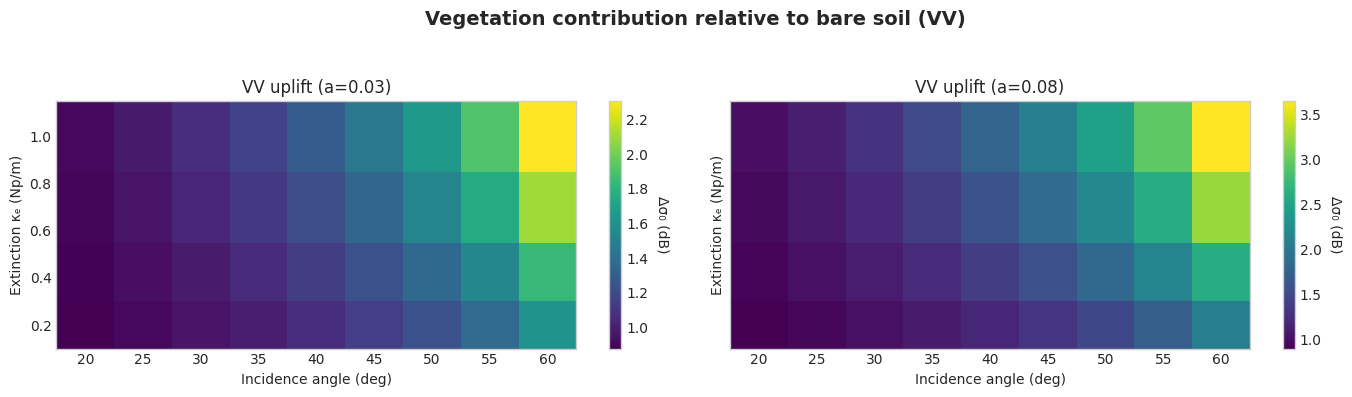

In [19]:
fig, axes = plt.subplots(1, len(albedos), figsize=(14, 4), sharey=True)
for ax, albedo in zip(axes, albedos):
    gain_matrix = np.array([canopy_results[albedo][k]['uplift_vv'] for k in kappas])
    mesh = ax.pcolormesh(angles, kappas, gain_matrix, cmap='viridis', shading='auto')
    ax.set_title(f'VV uplift (a={albedo:.02f})')
    ax.set_xlabel('Incidence angle (deg)')
    ax.set_ylabel('Extinction κₑ (Np/m)')
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label('Δσ₀ (dB)', rotation=270, labelpad=15)
fig.suptitle('Vegetation contribution relative to bare soil (VV)', fontsize=14, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [20]:
angles_to_inspect = [30, 40, 55]
rows = []
for albedo in albedos:
    for kappa in kappas:
        res = canopy_results[albedo][kappa]
        for theta in angles_to_inspect:
            idx = np.where(angles == theta)[0][0]
            rows.append({
                'Albedo': albedo,
                'κₑ (Np/m)': kappa,
                'Incidence (deg)': theta,
                'Ground VV (dB)': float(res['ground_vv'][idx]),
                'Total VV (dB)': float(res['total_vv'][idx]),
                'VV uplift (dB)': float(res['uplift_vv'][idx]),
                'Ground HH (dB)': float(res['ground_hh'][idx]),
                'Total HH (dB)': float(res['total_hh'][idx]),
                'HH uplift (dB)': float(res['uplift_hh'][idx]),
            })
impact_table = pd.DataFrame(rows)
impact_table


,Albedo,κₑ (Np/m),Incidence (deg),Ground VV (dB),Total VV (dB),VV uplift (dB),Ground HH (dB),Total HH (dB),HH uplift (dB)
0,0.03,0.2,30,-27.233481,-7.682846,0.951229,-26.569431,-10.742131,0.800517
1,0.03,0.2,40,-30.289475,-10.335389,1.061079,-29.198486,-15.443433,0.840816
2,0.03,0.2,55,-31.104588,-13.333314,1.364737,-29.601756,-22.109805,1.191808
3,0.03,0.4,30,-27.233481,-7.650142,0.983933,-26.569431,-10.693862,0.848785
4,0.03,0.4,40,-30.289475,-10.265250,1.131218,-29.198486,-15.315440,0.968809
5,0.03,0.4,55,-31.104588,-13.158959,1.539092,-29.601756,-21.714277,1.587336
6,0.03,0.7,30,-27.233481,-7.609486,1.024589,-26.569431,-10.634121,0.908526
7,0.03,0.7,40,-30.289475,-10.178972,1.217496,-29.198486,-15.160372,1.123877
8,0.03,0.7,55,-31.104588,-12.950388,1.747663,-29.601756,-21.266076,2.035538
9,0.03,1.0,30,-27.233481,-7.577021,1.057054,-26.569431,-10.586628,0.956020


**Key observations**

- SPM3D remains within ≈1 dB of the NMM3D LUT for VV/HH across all ratios, providing a robust soil baseline for SSRT.
- Vegetation effects grow with both incidence angle and extinction coefficient; high κₑ (dense canopy) produces >4 dB VV uplift near 55°.
- Lower albedo can even reduce the HH return at shallow angles (absorption dominates), while higher albedo drives consistent increases in both polarisations.
- These scenarios can be extended by swapping `SPM3D` for other bare-soil models (PRISM1, Dubois95, SMART, I2EM) and exploring additional canopy permittivity or thickness settings.
